In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.layers import Dense
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import EarlyStopping

In [2]:
# check GPU
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(X_train, y_train_labels), (X_test, y_test_labels) = fashion_mnist.load_data()

print(X_train.shape, X_test.shape)
print(y_train_labels.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,)


Number: 2


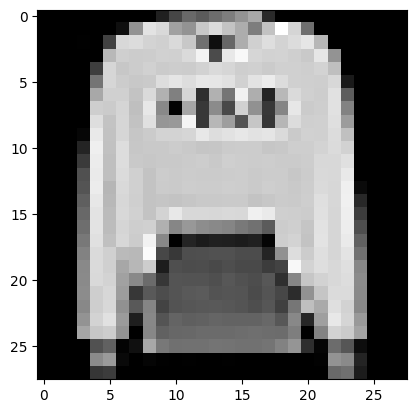

In [4]:
# random thing
index = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[index], cmap="gray")
print(f"Number: {y_train_labels[index]}")
plt.show()

In [5]:
# Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train.min(), X_train.max()

X_train = X_train.reshape((-1, 28 * 28))
X_test = X_test.reshape((-1, 28*28))
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [6]:
# one hot
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Epoch 1/4
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7763 - accuracy: 0.7434 - val_loss: 0.5590 - val_accuracy: 0.8033
Epoch 2/4
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5056 - accuracy: 0.8231 - val_loss: 0.4965 - val_accuracy: 0.8263
Epoch 3/4
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4576 - accuracy: 0.8389 - val_loss: 0.4627 - val_accuracy: 0.8365
Epoch 4/4
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4311 - accuracy: 0.8490 - val_loss: 0.4474 - val_accuracy: 0.8398
Epoch 1/4
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2656 - accuracy: 0.6225 - val_loss: 0.8952 - val_accuracy: 0.7067
Epoch 2/4
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7912 - accuracy: 0.7486 - val_loss: 0.7460 - val_accuracy: 0.7554
Epoch 3/4
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6938 - accuracy: 0.7756 - val_loss: 0.6845 - val_accuracy: 0.7722

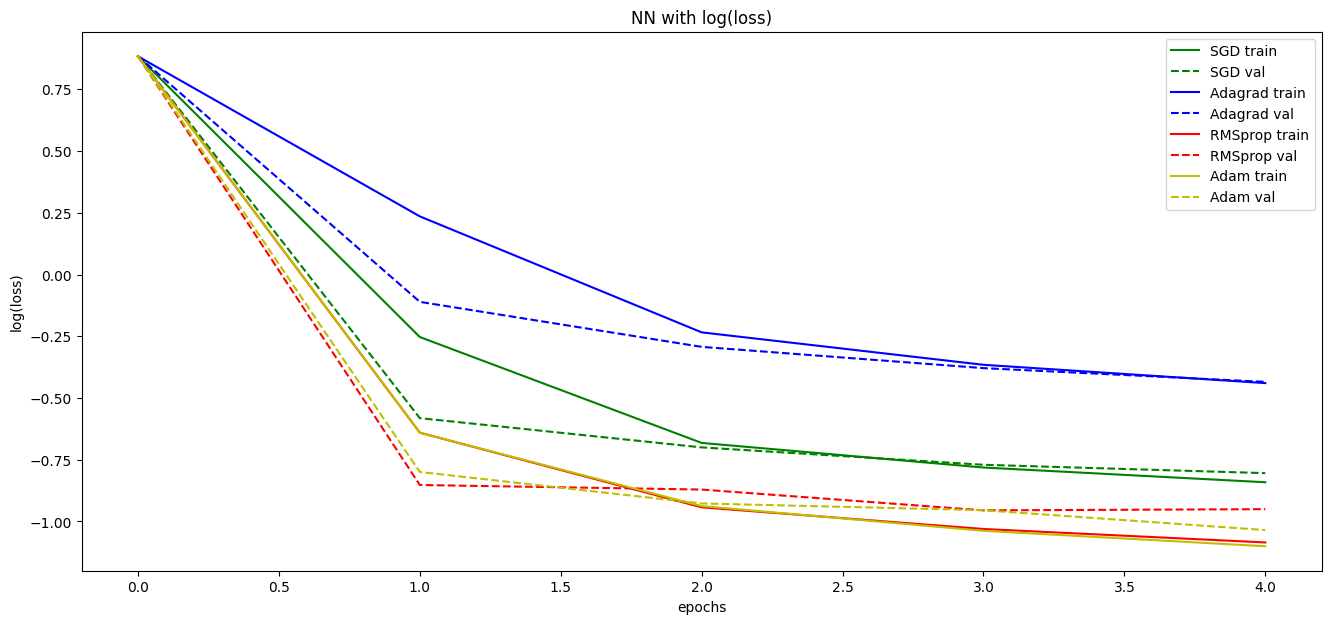

CPU times: total: 2min 5s
Wall time: 1min 42s


In [7]:
%%time

# optimizers comparison
models = {}

plt.figure(figsize=(16, 7))
colors = ['g', 'b', 'r', 'y']

num_epochs = 4
batch_size = 32

epoch = np.arange(num_epochs+1)

for i, i_optim in enumerate([optimizers.gradient_descent_v2.SGD(),
                             optimizers.adagrad_v2.Adagrad(),
                             optimizers.rmsprop_v2.RMSProp(),
                             optimizers.adam_v2.Adam()
                            ]):
    model_i = Sequential([
        Dense(64, input_shape=(28*28,), activation='relu'),
        Dense(32, activation='relu'),
        Dense(10, activation='sigmoid')
    ])

    model_i.load_weights('./samples/experimental_weights.h5')

    model_i.compile(
        optimizer=i_optim,
        loss='categorical_crossentropy',
        metrics='accuracy'
    )

    h0_train = model_i.evaluate(X_train, y_train, verbose=0)
    h0_val = model_i.evaluate(X_test, y_test, verbose=0)

    h = model_i.fit(X_train, y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    verbose=0)

    models[i_optim.get_config()['name']] = model_i

    plt.plot(epoch, np.log([h0_train[0]] + h.history['loss']), '-', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' train')

    plt.plot(epoch, np.log([h0_val[0]] + h.history['val_loss']), '--', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' val')

    print('=' * 20)

plt.legend()
plt.title('NN with log(loss)')
plt.xlabel('epochs')
plt.ylabel('log(loss)')
plt.show()

# choice -> adam

In [ ]:
import keras.backend as K
batches = [50, 70, 90, 110, 128, 140, 150, 160, 250]

for batch in batches:
    K.clear_session()  # clear GPU
    model = Sequential([
        Dense(18, input_shape=(28*28,), activation='relu'),
        Dense(15, activation='relu'),
        Dense(10, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, batch_size=batch, epochs=10, verbose=1)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f'epochs: {batch} | Test Loss: {loss:.3f} | Test Accuracy: {accuracy:.3f}')

Epoch 1/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.6358 - accuracy: 0.7790
Epoch 2/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.4421 - accuracy: 0.8444
Epoch 3/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.4121 - accuracy: 0.8534
Epoch 4/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.3884 - accuracy: 0.8618
Epoch 5/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.3747 - accuracy: 0.8659
Epoch 6/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.3634 - accuracy: 0.8696
Epoch 7/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.3530 - accuracy: 0.8736
Epoch 8/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.3442 - accuracy: 0.8764
Epoch 9/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.3368 - accuracy: 0.8792
Epoch 10/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.331